# Deep Learning Exam - Matteo Fusconi 
#### 10 June 2023

# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [2]:
!pip install datasets
!pip3 install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 84.0 MB/s eta 0:

In [3]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np 
import pickle
import gdown
import random

In [5]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]


# Tokenization	
tokenizer.fit_on_texts(corpus)
#print(tokenizer.word_index['<unk>'])

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']
#print(eos)
#print(tokenizer.index_word[sos])

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [7]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

Let us look at some examples:

In [8]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 135, 5, 393, 1414, 988, 3]
shuffled sentecen:  [2, 1414, 988, 135, 393, 5, 3]


Let us look at detokenized data:

In [9]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> potter palmer d <end>
shuffled sentence:  <start> potter palmer d <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)


Depending from the model you plan to build, you might require padding the input sequence

In [10]:
max_sequence_len = max([len(x) for x in original_data])

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

In [12]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 96110


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

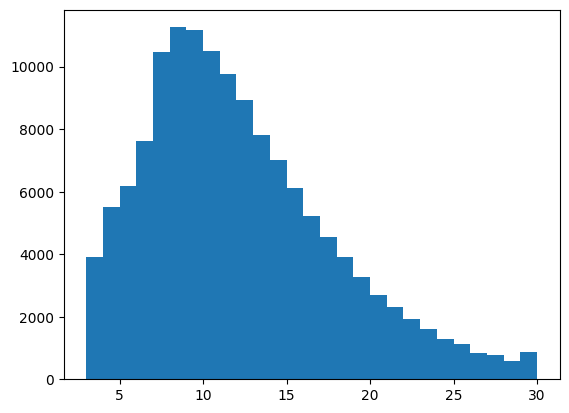

In [13]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [11]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(s),len(p)))

Let's do an example.

In [15]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ", score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented. 
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training. 
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

# 1. More data preprocessing



First of all, as suggested, I perform another split on the train set, in order to get a validation sample of data, which will be the 10% of the up to now collected data.

In [12]:
x_train_, x_val, c_train_, c_val = train_test_split(x_train, c_train, test_size = 0.1, random_state = 42)

Then I collect more paragraphs from the wikipedia dataset. I perform the same preprocessing, I filter the sentences that contain a "\<unk>" character, and I attach the good ones to the training dataset.

It is important to note that both the tokenizer and the test set are left unchanged.

In [17]:
data_extended = dataset['train'][20000:]['text']
corpus = []
for elem in data_extended:
  corpus +=elem.lower().replace("\n", "").split(".")[:]
corpus = ['<start> '+s+' <end>' for s in corpus]
original_data_extension = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen)) if 1 not in sen]
shuffled_data_extension = [random.sample(s[1:-1],len(s)-2) for s in original_data_extension]
shuffled_data_extension = [[sos]+s+[eos] for s in shuffled_data_extension]

x_train_extension = pad_sequences(original_data_extension, maxlen=max_sequence_len, padding='post')
c_train_extension = pad_sequences(shuffled_data_extension, maxlen=max_sequence_len, padding='post')

In [18]:
dataset2 = load_dataset("wikipedia", "20220301.en")

Downloading:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/20.3G [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.en/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
data_extended2 = dataset2['train'][:50000]['text']

corpus = []
for elem in data_extended2:
  corpus +=elem.lower().replace("\n", "").split(".")[:]
corpus = ['<start> '+s+' <end>' for s in corpus]
original_data_extension = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen)) if 1 not in sen]

# This line serves to delete any overlapping between the new data and the test set.
data_extended2 = list(set(map(tuple, data_extended)).difference(set(map(tuple, x_test))))

shuffled_data_extension = [random.sample(s[1:-1],len(s)-2) for s in original_data_extension]
shuffled_data_extension = [[sos]+s+[eos] for s in shuffled_data_extension]

x_train_extension2 = pad_sequences(original_data_extension, maxlen=max_sequence_len, padding='post')
c_train_extension2 = pad_sequences(shuffled_data_extension, maxlen=max_sequence_len, padding='post')

In [20]:
x_train_extended = np.concatenate([x_train_, x_train_extension, x_train_extension2])
c_train_extended = np.concatenate([c_train_, c_train_extension, c_train_extension2])

In [116]:
print(f"Total number of sentences used for train:\t{x_train_extended.shape[0]}")
print(f"Total number of sentences used for validation:\t{x_val.shape[0]}")
print(f"Total number of sentences used for test:\t{x_test.shape[0]}")

Total number of sentences used for train:	1216558
Total number of sentences used for validation:	9611
Total number of sentences used for test:	41191


Here I merge the train and validation data in a proper tf.data.Dataset object. I already batch the data and I process it so that it contains tuples of (input, labels) where:
- input = (context, target_in)
- labels = target_out

target_in and target_out are the same sequences, where the first does not contain the last padding, and the second does not contain the \<start> token

In [14]:
import time
import tensorflow as tf

BATCH_SIZE = 256
BUFFER_SIZE = tf.data.AUTOTUNE

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((c_train_extended, x_train_extended))
    .batch(BATCH_SIZE)
    .prefetch(BUFFER_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((c_val, x_val))
    .batch(BATCH_SIZE)
    .prefetch(BUFFER_SIZE))

def process_text(context, target):
    targ_in = target[:,:-1]
    targ_out = target[:,1:]
    return (context, targ_in), targ_out

# shapes:
# context =   (batch, 32)
# targ_in =   (batch, 31)
# targ_out =  (batch, 31)

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

# 2. Training

I have approached this problem using a classic Transformer architecture, following the guidelines of the paper _Attention is all you need_. I have kept the same structure but I had to change some hyperparameters in order to satisfy the constraint of having less than 20 millions of parameters. 


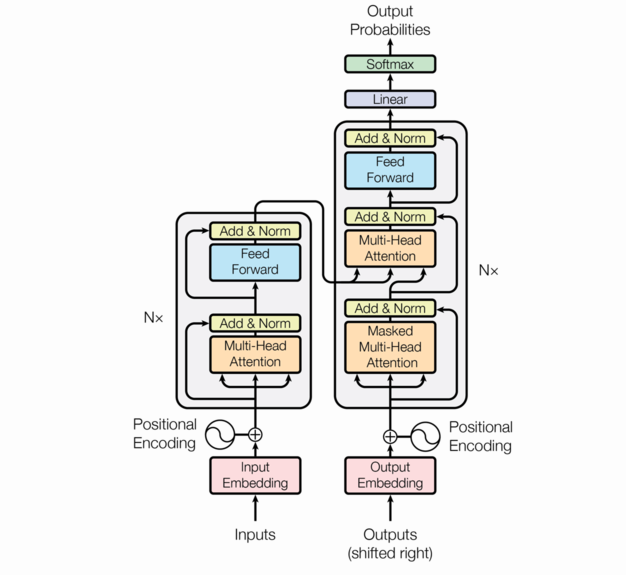

### Basic Components

In [15]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  # Layer that performs sequentially the positional encoding and the embedding
  def __init__(self, vocab_size, d_model, pos = True):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    self.pos = pos

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    
    if self.pos:
      # This factor sets the relative scale of the embedding and positonal_encoding.
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x = x + self.pos_encoding[tf.newaxis, :length, :]

    return x

In [16]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=False)

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


In [17]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [19]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

### Model

In [20]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=vocab_size,
                           dropout_rate=dropout_rate)
 
    self.final_layer = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs):
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model) 

    x = self.decoder(x, context)  # (batch_size, target_len, d_model) 

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Fit

#### Hyperparameters:
I tried several combinations of parameters, and this is one that turned to be very good for this task. In particular:
- **d_model**: the embedding dimension has been lowered in order to decrease the total number of parameters. Since it is not a completely generative task (the output words are the just a permutation of the input ones), it happens that 128 dimensions are enough to comprise effectively the information of a word.
- **num_head**: the number of heads inside the Multi-Head-Attention modules affects in general the correlations between slices of inputs. More heads capture different correlations. This turns to be just what is needed for the task, so the idea is to boost this number (from 8 in the paper to 25), rather than having too many layers (**num_layers** is 3 from 6 in the paper).
- **dff** (the dimension of the FeedForward blocks) and the **dropout_rate** are just numbers that seemed reasonable.

In [21]:
num_layers = 3
d_model = 128
dff = 512
num_heads = 25
dropout_rate = 0.2

Transformer model definition, construction and summary. Note that the 20M parameters contraint is satisfied.

In [22]:
transformer = Transformer(
    num_layers= num_layers,
    d_model= d_model,
    num_heads= num_heads,
    dff= dff,
    vocab_size= 10000,
    dropout_rate= dropout_rate)

for (c, x), y in train_ds.take(1):
  print(c.shape, x.shape)
  break

output = transformer((c, x))

transformer.summary()

(256, 32) (256, 31)
Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  6621056   
                                                                 
 decoder (Decoder)           multiple                  11566208  
                                                                 
 dense_12 (Dense)            multiple                  1290000   
                                                                 
Total params: 19,477,264
Trainable params: 19,477,264
Non-trainable params: 0
_________________________________________________________________


#### Compilation
- As optimizer I choose Adam with weight decay, using a custom schedule well-suited for transformer models.
- As loss I use a special version of the ___sparse cathegorical crossentropy___, that applies a mask to ignore the padding tokens.
- As metric to monitor the training procedure, I use a version of the accuracy that applies the same mask to avoid considering padding tokens

In [263]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [264]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.AdamW(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9, weight_decay = 0.005)

In [265]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [266]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

#### Fit


In [267]:
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", patience=5, restore_best_weights=True)

In [268]:
transformer.fit(train_ds, 
                epochs= 37, 
                validation_data= val_ds, 
                shuffle= True, 
                callbacks= [es])

Epoch 1/37
4753/4753 [==============================] - 728s 147ms/step - loss: 3.2770 - masked_accuracy: 0.5174 - val_loss: 2.1999 - val_masked_accuracy: 0.5841
Epoch 2/37
4753/4753 [==============================] - 465s 98ms/step - loss: 1.2318 - masked_accuracy: 0.7183 - val_loss: 1.3718 - val_masked_accuracy: 0.6862
Epoch 3/37
4753/4753 [==============================] - 465s 98ms/step - loss: 0.9783 - masked_accuracy: 0.7564 - val_loss: 1.1434 - val_masked_accuracy: 0.7252
Epoch 4/37
4753/4753 [==============================] - 465s 98ms/step - loss: 0.8755 - masked_accuracy: 0.7740 - val_loss: 1.0248 - val_masked_accuracy: 0.7426
Epoch 5/37
4753/4753 [==============================] - 465s 98ms/step - loss: 0.8132 - masked_accuracy: 0.7853 - val_loss: 0.9654 - val_masked_accuracy: 0.7526
Epoch 6/37
4753/4753 [==============================] - 464s 98ms/step - loss: 0.7705 - masked_accuracy: 0.7934 - val_loss: 0.9152 - val_masked_accuracy: 0.7615
Epoch 7/37
4753/4753 [===========

#### Why 37?
On my trials it turned to be that the optimal number of epoch was between 35 and 40, so I decided to run 37 epochs

In [38]:
from google.colab import drive
drive.mount("/content/drive")

transformer.save_weights("/content/drive/MyDrive/TransformerModel_2/weights")

Mounted at /content/drive


# 3. Inference

Once fitted the transformer model, it is necessary to build a class that performs the actual reordering of the sentences.
In a glance, this is what the Predict module does. 

For each batch, for each sentence in the batch:
- initialize the decoder with the \<start> token
- calculates the padding and the look ahead masks from the shuffled sentences taken in input
- iteratively run the decoder, which will return a new token (a new word), and concatenate with the precedents, which will be the input of the decoder in the following iterations
- detokenize the sentence and output it

In [24]:
def replacing(string):
  while "<pad>" in string:
    string = string.replace("<pad>","")
  string = string.replace("<end>","")
  string = string.rstrip()
  return string

def tokens_to_text(tokens): 
  result = tf.strings.regex_replace(tokens, '<[^>]+>','')
  result = tf.strings.regex_replace(result, ' +', ' ')  # Normalize multiple spaces to a single space
  result = tf.strings.strip(result)
  return result

In [25]:
class Predict(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer
    self.start = tokenizers.word_index['<start>']
    self.end = tokenizers.word_index['<end>']

  def __call__(self,test):    
    predictions = []
    total_iter = tf.shape(test)[0] // BATCH_SIZE
    res = []
    for i in range(total_iter):
      # In order to compute the predict of 1 batch at a time, first I set indeces where the batch
      # starts and finishes, then I slice batch data from the dataset
      start_time = time.time()

      st_idx = i*BATCH_SIZE
      end_idx = i*BATCH_SIZE + BATCH_SIZE
      
      batch_data = test[st_idx:end_idx] 
      
      results = self.predict(batch_data)
      
      end_time = time.time()
      total_time = end_time - start_time
      
      print(f"total time for {i+1}th iteration = {round(total_time,2)} seconds")
      batch_sentences = tokens_to_text(results)
      res.append(batch_sentences)
    return res

  def predict(self, encoder_input, max_length=32):
    batch_size = encoder_input.shape[0]
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

    start = np.array(self.start, ndmin=1)
    output_array = output_array.write(0, tf.tile(start, [batch_size]))

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the decoder as its input.
      output_array = output_array.write(i+1, predicted_id[:, 0])
      
      end_mask = tf.reduce_any(tf.equal(predicted_id, self.end), axis=-1)
      if tf.reduce_all(end_mask):
            break

    output = tf.transpose(output_array.stack())
    tokens_list = output.numpy().tolist()
    sentence = [tokenizer.sequences_to_texts([row])[0] for row in tokens_list]

    self.transformer([encoder_input, output[:,:-1]], training=False)

    return sentence

In [26]:
orderer = Predict(tokenizer, transformer)

In [46]:
EXAMPLES_TO_TEST = 3000
N_BATCHES = int(np.ceil(EXAMPLES_TO_TEST / BATCH_SIZE))

indexes = list(range(len(y_test)))

randomizer.shuffle(indexes)
indexes = indexes[:N_BATCHES * BATCH_SIZE]

y_test_selected = y_test[indexes]
c_test_selected = c_test[indexes]

print(f"Batches to test: {N_BATCHES}")
result = orderer(c_test_selected)

Batches to test: 12
total time for 1th iteration = 5.5 seconds
total time for 2th iteration = 5.51 seconds
total time for 3th iteration = 5.7 seconds
total time for 4th iteration = 5.76 seconds
total time for 5th iteration = 5.72 seconds
total time for 6th iteration = 5.55 seconds
total time for 7th iteration = 5.12 seconds
total time for 8th iteration = 5.34 seconds
total time for 9th iteration = 5.59 seconds
total time for 10th iteration = 5.8 seconds
total time for 11th iteration = 5.63 seconds
total time for 12th iteration = 5.82 seconds


### Inspect the ground truth and the predicted sentences

In [47]:
y_test_to_evaluate = [replacing(s) for s in tokenizer.sequences_to_texts(y_test_selected)]

In [40]:
how_many = 10

for i in range(how_many):
  print(f"Sentence number {i+1}:")
  print(f"Predicted: \t{   result[0][i].numpy()  }")
  print(f"Ground truth:\t{ y_test_to_evaluate[i]  }")
  print()

Sentence number 1:
Predicted: 	b'hamilton wrote about two thirds of the essays'
Ground truth:	hamilton wrote about two thirds of the essays

Sentence number 2:
Predicted: 	b'wellington is the capital of new zealand'
Ground truth:	wellington is the capital of new zealand

Sentence number 3:
Predicted: 	b"they would later be sad on the band's next album wings of destiny in 1976"
Ground truth:	they would later be on the band's next album sad wings of destiny in 1976

Sentence number 4:
Predicted: 	b'humans hunt for food and some animals'
Ground truth:	animals and some humans hunt for food

Sentence number 5:
Predicted: 	b'though below the line of water it is some'
Ground truth:	some of it though is below the water line

Sentence number 6:
Predicted: 	b'1994 1913 walt kelly american cartoonist d'
Ground truth:	1994 1913 walt kelly american cartoonist d

Sentence number 7:
Predicted: 	b'richard high school was excellent in baseball and in basketball'
Ground truth:	richard was excellent in b

# 4. Score
Finally I perform the calculation of the score, based on the given score function which is the concept of an interception over union, applied to text sequences rather than images.

The final value is the mean over the scores of the sentences of the selected portion of the test set. The latter contains at least 3000 sentences sampled from the test set (actually the nearest multiple of the batch_size over 3000).

In [29]:
def evaluate(y_test_to_evaluate, results):
    i = 0
    scores = []

    for j in range(len(results) - 1):
      for k in range(BATCH_SIZE):
        scores.append(score(results[j][k].numpy().decode("utf-8"), y_test_to_evaluate[i] ))
        i = i + 1

    return  np.mean(scores)

In [48]:
final_score = evaluate(y_test_to_evaluate, result)
print(f"The final score is {np.round(final_score, 4)}")

The final score is 0.58


# 5. Summary and Conclusions
Sentence Reordering is a well-known task in the intersection of the field of NLP, and of the field of sequence to sequence (seq2seq) algorithms.

So, first of all I tried to tackle the problem following a **standard RNN encoder-decoder** approach, using different types of cells (GRU and LSTM), as well as different combinations of hyperparameters. However, I wasn't able to get a score higher than 0.48.

Then I tried a **transformer** approach, which from the beginning showed better results. I proceeded to hypertune it, and I came to a score of around 0.53.

The last turning point has been the inclusion of much more sentences to the training set, which led me to the final score of 0.5800